### Acknowledgements

First, a huge thank you to [LucidRains](https://github.com/lucidrains) for his amazing work creating dalle2 model repo.

Thank you to [Nousr](https://twitter.com/nousr_) and [Aidan](https://github.com/Veldrovive) for their work on the training scripts for the prior and decoder. As well, thank you to [Romain](https://github.com/rom1504) for his work on enabling multi-node training and for his part in creating the dataset.

This was trained thanks to the generous donation of compute time from [LAION](https://laion.ai/) and its sponsors, especially [StabilityAI](https://stability.ai/) for the servers used in this project.
This model was trained using the aesthetic subset of the [LAION2B dataset](https://laion.ai/blog/laion-5b/), details of the run can be found on [wandb](https://wandb.ai/nousr_laion/dalle2_train_decoder/reports/Decoder-Training--VmlldzoyMjEyMjcw).

#### This is a WIP notebook.
It is missing the upsamplers so it can only produce 64x64 images and has only be trained for 0.5% of what OpenAI did for their DALLE2. It can still produce some impressive results, but is not nearly at the level you might see on the news yet.

While the upsamplers have yet to be trained, we have substituted [SwinIR](https://github.com/JingyunLiang/SwinIR) to produce 256x256 images. This tends to flatten details, but still generally improves the quality of the output.

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


### Setup

In [2]:
#@title
!pip install -q ipywidgets
import ipywidgets as widgets
import sys
import os
import json

decoder_versions = [{
    "name": "Original",
    "dalle2_install_path": "git+https://github.com/Veldrovive/DALLE2-pytorch@f4b687798d367fc434d8127ab31141f0fea0db26",
    "decoder_path": "https://huggingface.co/Veldrovive/DA-VINC-E/resolve/main/text_conditioned_epoch_34.pth",
    "config_path": "https://huggingface.co/Veldrovive/DA-VINC-E/raw/main/text_conditioned_config.json"
},{
    "name": "New 1B (Aesthetic)",
    "dalle2_install_path": "dalle2_pytorch==0.15.4",
    "decoder_path": "https://huggingface.co/laion/DALLE2-PyTorch/resolve/main/decoder/small_32gpus/latest.pth",
    "config_path": "https://huggingface.co/laion/DALLE2-PyTorch/raw/main/decoder/small_32gpus/decoder_config.json"
},{
    "name": "New 1.5B (Aesthetic)",
    "dalle2_install_path": "dalle2_pytorch==0.15.4",
    "decoder_path": "https://huggingface.co/laion/DALLE2-PyTorch/resolve/main/decoder/1.5B/latest.pth",
    "config_path": "https://huggingface.co/laion/DALLE2-PyTorch/raw/main/decoder/1.5B/decoder_config.json"
},{
    "name": "New 1.5B (Laion2B)",
    "dalle2_install_path": "dalle2_pytorch==0.15.4",
    "decoder_path": "https://huggingface.co/laion/DALLE2-PyTorch/resolve/main/decoder/1.5B_laion2B/latest.pth",
    "config_path": "https://huggingface.co/laion/DALLE2-PyTorch/raw/main/decoder/1.5B_laion2B/decoder_config.json"
}]

decoder_options = [version["name"] for version in decoder_versions]

def load_state():
    state_path = "script_state.json"
    try:
        assert os.path.exists(state_path)
        with open(state_path, "r") as f:
            state = json.load(f)
        # Make sure the save config is up to date. You might think this is a stupid system but...
        decoder = state["decoder"]
        if decoder is not None:
          current_decoder_name = decoder["name"]
          try:
              current_decoder_index = decoder_options.index(current_decoder_name)
              state["decoder"] = decoder_versions[current_decoder_index]
          except ValueError:
              print("The decoder you were using no longer exists. Please pick a new option.")
              state["decoder"] = None
        
        # Check if models are where they say they are
        for filekey in ["decoder", "decoder_config", "prior", "prior_config"]:
            path = state["model_paths"][filekey]
            if path is not None and not os.path.exists(path):
                print(f"{filekey} not found in expected place. Removing decoder config.")
                state["decoder"] = None
                state["model_paths"] = {
                    "decoder": None,
                    "decoder_config": None,
                    "prior": None,
                    "prior_config": None
                }
                save_state()
    except Exception as e:
        state = {
            "text_input": '',
            "text_repeat": 3,
            "prior_conditioning": 1.0,
            "img_repeat": 1,
            "decoder_conditioning": 3.5,
            "include_prompt_checkbox": True,
            "upsample_checkbox": True,
            "decoder": None,
            "model_paths": {
                "decoder": None,
                "decoder_config": None,
                "prior": None,
                "prior_config": None
            }
        }
    return state

current_state = load_state()

def save_state():
    global current_state
    state_path = "script_state.json"
    with open(state_path, "w") as f:
        json.dump(current_state, f)

def choice_equal(new_choice):
    global current_state
    if current_state["decoder"] is None:
        return False
    return current_state["decoder"]["decoder_path"] == new_choice["decoder_path"]

def dalle2_imported():
    return "dalle2_pytorch" in sys.modules

chosen_decoder = current_state["decoder"] if current_state["decoder"] is not None else decoder_versions[-1]

decoder_version_dropdown = widgets.Dropdown(
    options=decoder_options,
    value=chosen_decoder["name"],
    description='Decoder:',
    disabled=False,
)

start_setup_button = widgets.Button(
    description="Setup"
)

redownload_button = widgets.Button (
    description="Force Update Models"
)

main_layout = widgets.VBox([decoder_version_dropdown, start_setup_button, redownload_button])

def setup(decoder_version_name):
    global current_state
    global chosen_decoder
    new_choice = decoder_versions[decoder_options.index(decoder_version_name)]
    current_choice = current_state["decoder"]
    
    new_choice_equal = choice_equal(new_choice)
    already_imported = dalle2_imported()
    
    requires_restart = not new_choice_equal and already_imported  # The wrong dalle2_pytorch version is already imported
    requires_download = not new_choice_equal  # The wrong decoder version is downloaded
    
    print(f"You are using the model {new_choice['name']} which will be downloaded from {new_choice['decoder_path']}\n")
    if requires_restart:
        print("You environment already has dalle2 imported and collab requires a restart for you to be able to import the new version.")
        print("Restart your runtime to proceed.")
    elif requires_download:
        print("The models are not downloaded. They will be when you proceed.")
    else:
        print("You are ready to run inference. If you suspect your models are out of date, force update them.")
    
    chosen_decoder = new_choice
    

out = widgets.interactive_output(setup, { 'decoder_version_name': decoder_version_dropdown })
display(main_layout, out)

def download_models(current_choice):
    model_dir = "./models"
    os.makedirs(model_dir, exist_ok=True)
    
    # Download decoder
    print("Downloading decoder and decoder config")
    decoder_url = current_choice["decoder_path"]
    decoder_config_url = current_choice["config_path"]

    decoder_path = os.path.join(model_dir, "decoder.pth")
    decoder_config_path = os.path.join(model_dir, "decoder_config.json")
    
    !curl -L {decoder_url} > {decoder_path}
    !curl -L {decoder_config_url} > {decoder_config_path}
    
    # Download prior
    print("Downloading prior and prior config")
    prior_url = "https://huggingface.co/zenglishuci/conditioned-prior/resolve/main/vit-l-14/prior_aes_finetune.pth"
        
    prior_path = os.path.join(model_dir, "prior.pth")
    
    !curl -L {prior_url} > {prior_path}
    return decoder_path, decoder_config_path, prior_path, None

def install_dependencies(state):
    print("Installing dependencies")
    dalle2_install_path = state["decoder"]["dalle2_install_path"]
    print(f"Installing dalle2 version {dalle2_install_path}")
    !pip install -q {dalle2_install_path}
    
    !pip install -q matplotlib

    print("Do not worry if you get the error `fatal: destination path 'SwinIR' already exists and is not an empty directory.`")
    print("That just means SwinIR is already installed and I'm too lazy to do the check myself")
    !git clone https://github.com/JingyunLiang/SwinIR.git
    !pip install -q timm
    !pip install -q opencv-python

def start_setup(b):
    global current_state
    global chosen_decoder
    current_choice = current_state["decoder"]
    
    new_choice_equal = choice_equal(chosen_decoder)
    already_imported = dalle2_imported()
    
    requires_restart = not new_choice_equal and already_imported  # The wrong dalle2_pytorch version is already imported
    requires_download = not new_choice_equal  # The wrong decoder version is downloaded
    
    if requires_restart:
        raise Exception("Please restart your runtime before trying to set up the environment")
        
    if requires_download:
        try:
            decoder_path, decoder_config_path, prior_path, prior_config_path = download_models(chosen_decoder)
        except Exception as e:
            print("Model download was interrupted. Manually delete all models or environment may be corrupted.")
            current_state["decoder"] = None
            save_state()
            raise e
        current_state["decoder"] = chosen_decoder
        current_state["model_paths"] = {
                "decoder": decoder_path,
                "decoder_config": decoder_config_path,
                "prior": prior_path,
                "prior_config": prior_config_path
            }
        save_state()
    
    install_dependencies(current_state)

start_setup_button.on_click(start_setup)

def force_download(b):
    global current_state
    current_choice = current_state["decoder"]
    updated_choice = decoder_versions[decoder_options.index(current_choice["name"])]
    chosen_decoder = updated_choice
    try:
        decoder_path, decoder_config_path, prior_path, prior_config_path = download_models(chosen_decoder)
    except Exception as e:
        print("Model download was interrupted. Force update models or environment may be corrupted.")
        current_state["decoder"] = None
        save_state()
        raise e
    current_state["decoder"] = chosen_decoder
    current_state["model_paths"] = {
            "decoder": decoder_path,
            "decoder_config": decoder_config_path,
            "prior": prior_path,
            "prior_config": prior_config_path
        }
    save_state()
    install_dependencies(current_state)
    
redownload_button.on_click(force_download)

Output()

In [3]:
#@title
# I would suggest running on a remote machine https://research.google.com/colaboratory/local-runtimes.html
import shutil
import torch
import os
import importlib


from dalle2_pytorch import DALLE2, DiffusionPriorNetwork, DiffusionPrior, OpenAIClipAdapter, train_configs
from dalle2_pytorch.tokenizer import tokenizer

import numpy as np


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load the decoder

In [4]:
#@title

def conditioned_on_text(config):
    try:
        return config.decoder.unets[0].cond_on_text_encodings
    except AttributeError:
        pass
    
    try:
        return config.decoder.condition_on_text_encodings
    except AttributeError:
        pass
    
    return False

decoder_text_conditioned = False
clip_config = None
def load_decoder(decoder_state_dict_path, config_file_path):
  config = train_configs.TrainDecoderConfig.from_json_path(config_file_path)
  global decoder_text_conditioned
  decoder_text_conditioned = conditioned_on_text(config)
  global clip_config
  clip_config = config.decoder.clip
  config.decoder.clip = None
  print("Decoder conditioned on text", decoder_text_conditioned)
  decoder = config.decoder.create().to(device)
  decoder_state_dict = torch.load(decoder_state_dict_path, map_location='cpu')
  decoder.load_state_dict(decoder_state_dict, strict=False)
  del decoder_state_dict
  decoder.eval()
  return decoder
decoder = load_decoder(current_state["model_paths"]["decoder"], current_state["model_paths"]["decoder_config"])

Decoder conditioned on text True


### Load the prior

In [5]:
#@title

def load_prior(model_path):
  prior_network = DiffusionPriorNetwork(
    dim=768,
    depth=24,
    dim_head=64,
    heads=32,
    normformer=True,
    attn_dropout=5e-2,
    ff_dropout=5e-2,
    num_time_embeds=1,
    num_image_embeds=1,
    num_text_embeds=1,
    num_timesteps=1000,
    ff_mult=4
  )

  diffusion_prior = DiffusionPrior(
    net=prior_network,
    clip=OpenAIClipAdapter("ViT-L/14"),
    image_embed_dim=768,
    timesteps=1000,
    cond_drop_prob=0.1,
    loss_type="l2",
    condition_on_text_encodings=True,
  ).to(device)

  state_dict = torch.load(model_path, map_location='cpu')
  if 'ema_model' in state_dict:
    print('Loading EMA Model')
    diffusion_prior.load_state_dict(state_dict['ema_model'], strict=True)
  else:
    print('Loading Standard Model')
    diffusion_prior.load_state_dict(state_dict['model'], strict=False)
  del state_dict
  return diffusion_prior
diffusion_prior = load_prior(current_state["model_paths"]["prior"])

100%|███████████████████████████████████████| 933M/933M [00:16<00:00, 55.7MiB/s]


Loading EMA Model


### Load Clip

In [6]:
#@title
clip = None
if clip_config is not None:
  clip = clip_config.create()

### Add helpers

In [7]:
#@title
from PIL import Image, ImageDraw, ImageFont

class ImageText(object):
    def __init__(self, filename_or_size, mode='RGBA', background=(0, 0, 0, 0), encoding='utf8'):
        if isinstance(filename_or_size, str):
            self.filename = filename_or_size
            self.image = Image.open(self.filename)
            self.size = self.image.size
        elif isinstance(filename_or_size, (list, tuple)):
            self.size = filename_or_size
            self.image = Image.new(mode, self.size, color=background)
            self.filename = None
        self.draw = ImageDraw.Draw(self.image)
        self.encoding = encoding

    def save(self, filename=None):
        self.image.save(filename or self.filename)

    def get_font_size(self, text, font, max_width=None, max_height=None):
        if max_width is None and max_height is None:
            raise ValueError('You need to pass max_width or max_height')
        font_size = 1
        text_size = self.get_text_size(font, font_size, text)
        if (max_width is not None and text_size[0] > max_width) or \
           (max_height is not None and text_size[1] > max_height):
            raise ValueError("Text can't be filled in only (%dpx, %dpx)" % \
                    text_size)
        while True:
            if (max_width is not None and text_size[0] >= max_width) or \
               (max_height is not None and text_size[1] >= max_height):
                return font_size - 1
            font_size += 1
            text_size = self.get_text_size(font, font_size, text)

    def write_text(self, xy, text, font_filename, font_size=11,
                   color=(0, 0, 0), max_width=None, max_height=None):
        x, y = xy
        # if isinstance(text, str):
        #     text = text.decode(self.encoding)
        if font_size == 'fill' and \
           (max_width is not None or max_height is not None):
            font_size = self.get_font_size(text, font_filename, max_width,
                                           max_height)
        text_size = self.get_text_size(font_filename, font_size, text)
        font = ImageFont.truetype(font_filename, font_size)
        # font = ImageFont.load_default()
        if x == 'center':
            x = (self.size[0] - text_size[0]) / 2
        if y == 'center':
            y = (self.size[1] - text_size[1]) / 2
        self.draw.text((x, y), text, font=font, fill=color)
        return text_size

    def get_text_size(self, font_filename, font_size, text):
        font = ImageFont.truetype(font_filename, font_size)
        return font.getsize(text)

    def write_text_box(self, xy, text, box_width, font_filename,
                       font_size=11, color=(0, 0, 0), place='left',
                       justify_last_line=False):
        x, y = xy
        lines = []
        line = []
        words = text.split()
        for word in words:
            new_line = ' '.join(line + [word])
            size = self.get_text_size(font_filename, font_size, new_line)
            text_height = size[1]
            if size[0] <= box_width:
                line.append(word)
            else:
                lines.append(line)
                line = [word]
        if line:
            lines.append(line)
        lines = [' '.join(line) for line in lines if line]
        height = y
        for index, line in enumerate(lines):
            if place == 'left':
                self.write_text((x, height), line, font_filename, font_size,
                                color)
            elif place == 'right':
                total_size = self.get_text_size(font_filename, font_size, line)
                x_left = x + box_width - total_size[0]
                self.write_text((x_left, height), line, font_filename,
                                font_size, color)
            elif place == 'center':
                total_size = self.get_text_size(font_filename, font_size, line)
                x_left = int(x + ((box_width - total_size[0]) / 2))
                self.write_text((x_left, height), line, font_filename,
                                font_size, color)
            elif place == 'justify':
                words = line.split()
                if (index == len(lines) - 1 and not justify_last_line) or \
                   len(words) == 1:
                    self.write_text((x, height), line, font_filename, font_size,
                                    color)
                    continue
                line_without_spaces = ''.join(words)
                total_size = self.get_text_size(font_filename, font_size,
                                                line_without_spaces)
                space_width = (box_width - total_size[0]) / (len(words) - 1.0)
                start_x = x
                for word in words[:-1]:
                    self.write_text((start_x, height), word, font_filename,
                                    font_size, color)
                    word_size = self.get_text_size(font_filename, font_size,
                                                    word)
                    start_x += word_size[0] + space_width
                last_word_size = self.get_text_size(font_filename, font_size,
                                                    words[-1])
                last_word_x = x + box_width - last_word_size[0]
                self.write_text((last_word_x, height), words[-1], font_filename,
                                font_size, color)
            height += text_height
        return (box_width, height - y)

def download_font():
  if not os.path.exists("./Arial.ttf"):
    !wget https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf
  return "./Arial.ttf"


def map_images(np_images, prior_repeat, decoder_repeat, prompts, upscale=4):
  # Match the images to their prompts
  # Format [{ prompt: STRING, images: [
  #  { prior_index: INT, decoder_index: INT, img: NP_ARR[64, 64, 3] }
  # ] }]
  image_map = {}
  curr_index = 0
  for prompt in prompts:
    for prior_index in range(prior_repeat):
      for decoder_index in range(decoder_repeat):
        img = np_images[curr_index]
        if prompt not in image_map:
          image_map[prompt] = []
        if isinstance(img, np.ndarray):
          image = Image.fromarray(np.uint8(img * 255))
          image = image.resize([dim * upscale for dim in image.size])
        else:
          image = img
        image_map[prompt].append({
            "prior_index": prior_index,
            "decoder_index": decoder_index,
            "img": image
        })
        curr_index += 1
  return image_map

def format_image_grid(img_array):
  example_image = img_array[0]["img"]
  max_prior_index = max((inst["prior_index"] for inst in img_array))
  cols = max_prior_index + 1
  max_decoder_index = max((inst["decoder_index"] for inst in img_array))
  rows = max_decoder_index + 1

  w, h = example_image.size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size
  
  for img_data in img_array:
    x_pos = img_data["prior_index"] * w
    y_pos = img_data["decoder_index"] * h
    grid.paste(img_data["img"], box=(x_pos, y_pos))
  return grid

def format_prompt_image(prompt, grid_img, font_size=20, horizontal_padding=10, vertical_padding=10):
  grid_w, grid_h = grid_img.size
  prompt_img = ImageText((grid_w, 2000), background=(255, 255, 255, 255))
  # font = ImageFont.load("arial.pil")
  # font = ImageFont.load_default()
  font_path = download_font()
  text_w, text_h = prompt_img.write_text_box((horizontal_padding, vertical_padding), prompt, box_width=grid_w - horizontal_padding, font_filename=font_path, font_size=font_size, color=(0, 0, 0), place='center')
  text_img = prompt_img.image
  text_img = text_img.crop((0, 0, grid_w, text_h + 2*vertical_padding))
  full_img = Image.new('RGB', (grid_w, text_img.size[1] + grid_h))
  full_img.paste(text_img, (0, 0))
  full_img.paste(grid_img, (0, text_img.size[1]))
  return full_img

def save_images(output_dir, np_images):
  os.makedirs(output_dir, exist_ok=True)
  for i, np_img in enumerate(np_images):
    image = Image.fromarray(np.uint8(np_img * 255))
    output_path = os.path.join(output_dir, f'{i}.png')
    image.save(output_path)

def upscale_dir(input_dir):
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq {input_dir} --scale 4 --large_model
  results_dir = "./results/swinir_real_sr_x4_large"
  output_files = sorted([file for file in os.listdir(results_dir) if '.png' in file], key=lambda e: int(e.split('_')[0]))
  upscale_dims = (256, 256, 3)
  images = [None] * len(output_files)
  for i, filename in enumerate(output_files):
    pil_img = Image.open(os.path.join(results_dir, filename))
    images[i] = pil_img
#   shutil.rmtree(results_dir)
  !rm {results_dir}
  return images

### Start Inference

Output()

Running prior


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Running decoder
Generating clip embeddings


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

downloading model experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Testing 0 0                   
Testing 1 1                   
Testing 2 2                   
rm: cannot remove './results/swinir_real_sr_x4_large': Is a directory
--2022-07-25 06:35:45--  https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf [following]
--2022-07-25 06:35:45--  https://raw.githubuserco

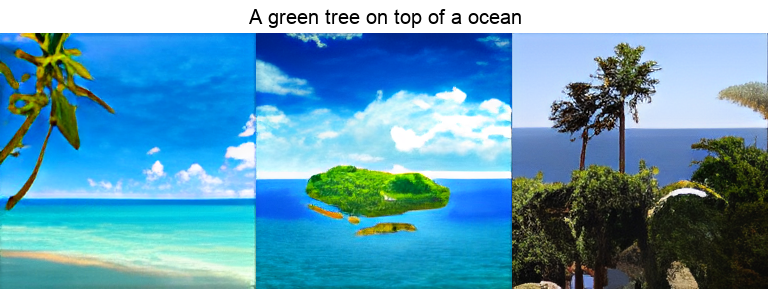

Button(description='Download', style=ButtonStyle())

In [8]:
#@title
from IPython.display import display, clear_output
from ipywidgets import interact
try:
  from google.colab import files
  can_download = True
except ImportError:
  can_download = False

text_input = widgets.Textarea(
    placeholder='Prompts separated by new lines...',
    value=str(current_state["text_input"]),
    disabled=False,
    continuous_update=True,
    layout={'width': 'auto'},
    rows=10
)
textbox_box = widgets.VBox([text_input], layout={'border': '2px solid grey'})

prior_label = widgets.HTML(value="<b>Prior Options:</b> Set how many sample to take from the prior and what conditioning scale to use.")
text_repeat = widgets.IntSlider(
    value=int(current_state["text_repeat"]),
    min=1,
    max=10,
    step=1,
    description='Text Repeat',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="100%")
)

prior_conditioning = widgets.FloatSlider(
    value=float(current_state["prior_conditioning"]),
    min=0.0,
    max=10.0,
    step=0.1,
    description='Prior Cond Scale',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="100%")
)
prior_options_box = widgets.VBox([prior_label, text_repeat, prior_conditioning], layout=widgets.Layout(border="2px solid grey", padding="5px 10px", flex="1 0 auto"))

decoder_label = widgets.HTML(value="<b>Decoder Options:</b> Set how many sample to take from the decoder and what conditioning scale to use.")
img_repeat = widgets.IntSlider(
    value=int(current_state["img_repeat"]),
    min=1,
    max=10,
    step=1,
    description='Img Repeat',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="100%")
)

decoder_conditioning = widgets.FloatSlider(
    value=float(current_state["decoder_conditioning"]),
    min=0.0,
    max=10.0,
    step=0.1,
    description='Decoder Cond Scale',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="100%")
)
decoder_options_box = widgets.VBox([decoder_label, img_repeat, decoder_conditioning], layout=widgets.Layout(border="2px solid grey", padding="5px 10px", flex="1 0 auto"))
main_options_box = widgets.HBox([prior_options_box, decoder_options_box], layout=widgets.Layout(width="100%"))

include_prompt_checkbox = widgets.Checkbox(
    value=bool(current_state["include_prompt_checkbox"]),
    description='Show prompt in output image',
    disabled=False,
    indent=False
)

upsample_checkbox = widgets.Checkbox(
    value=bool(current_state['upsample_checkbox']),
    description = 'Upsample to 256x256 with SwinIR',
    disabled=False,
    indent=False
)

meta_options_box = widgets.VBox([include_prompt_checkbox, upsample_checkbox])

button = widgets.Button(
    description="Start"
)
final_options_box = widgets.HBox([meta_options_box, button], layout=widgets.Layout(justify_content="space-between", border="2px solid grey", padding="10px 30px"))

main_layout = widgets.VBox([textbox_box, main_options_box, final_options_box])

def get_prompts():
  import json
  text = text_input.value
  try:
    prompts_array = json.loads(text)
    assert isinstance(prompts_array, list)
    return prompts_array
  except Exception as e:
#     print("Failed to read as json", e)
    pass
  
  try:
    return list(filter(lambda v: len(v) > 0, text.split("\n")))
  except Exception as e:
    print("Failed to read as text with newlines", e)
  
  return []

def f(text_input, text_repeat, prior_conditioning, img_repeat, decoder_conditioning, include_prompt_checkbox, upsample_checkbox):
  prompts = get_prompts()
  total_images = len(prompts) * text_repeat * img_repeat

  global current_state
  current_state = {
      **current_state,
      "text_input": text_input,
      "text_repeat": text_repeat,
      "prior_conditioning": prior_conditioning,
      "img_repeat": img_repeat,
      "decoder_conditioning": decoder_conditioning,
      "include_prompt_checkbox": include_prompt_checkbox,
      "upsample_checkbox": upsample_checkbox,
  }

  output_strings = []
  output_strings.append(f"Using model: {current_state['decoder']['name']}")
  output_strings.append(f"Total output images: {total_images}")
  output_strings.append("")
  output_strings.extend([f"Prompt {index}: {prompt}" for index, prompt in enumerate(prompts)])
  output_strings.append("")
  output_strings.append("Including prompt text in output image" if include_prompt_checkbox else "Not including prompt text in output image")
  output_strings.append(f"Prior Conditioning Scale: {prior_conditioning}")
  output_strings.append(f"Decoder Conditioning Scale: {decoder_conditioning}")
  print('\n'.join(output_strings))
  save_state()

out = widgets.interactive_output(f, {'text_input': text_input, 'text_repeat': text_repeat, 'prior_conditioning': prior_conditioning, 'img_repeat': img_repeat, 'decoder_conditioning': decoder_conditioning, 'include_prompt_checkbox': include_prompt_checkbox, 'upsample_checkbox': upsample_checkbox })

display(main_layout, out)

def on_start(_, recall_embeddings=False, recall_images=False):
  if os.path.exists("./output"):
    shutil.rmtree("./output")
  clear_output()
  display(main_layout, out)
  prompts = get_prompts()
  prior_cond_scale = prior_conditioning.value
  decoder_cond_scale = decoder_conditioning.value
  text_rep = text_repeat.value
  img_rep = img_repeat.value
  include_prompt = include_prompt_checkbox.value
  upsample = upsample_checkbox.value
  
  prior_text_input = []
  for prompt in prompts:
    for _ in range(text_rep):
      prior_text_input.append(prompt)
  
  tokens = tokenizer.tokenize(prior_text_input).to(device)
  if recall_embeddings:
    print("Loading embeddings")
    image_embed = np.load('img_emb_prior.npy')
  else:
    print("Running prior")
    with torch.no_grad():
      image_embed = diffusion_prior.sample(tokens, cond_scale = prior_cond_scale).cpu().numpy()
    np.save('img_emb_prior.npy', image_embed)

  embeddings = np.repeat(image_embed, img_rep, axis=0)
  embeddings = torch.from_numpy(embeddings).float().to(device)
  if recall_images:
    print("Loading images")
    images = np.load('images_decoder.npy')
  else:
    print("Running decoder")
    with torch.no_grad():
      if decoder_text_conditioned:
        print("Generating clip embeddings")
        _, text_encoding, text_mask = clip.embed_text(tokens)
        images = decoder.sample(embeddings, text_encodings = text_encoding, text_mask = text_mask, cond_scale = decoder_cond_scale)
      else:
        print("Not generating clip embeddings")
        images = decoder.sample(embeddings, text = None, cond_scale = decoder_cond_scale)
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    np.save('images_decoder.npy', images)

  if upsample:
    save_images('output/images', images)
    images = upscale_dir('output/images')

  img_map = map_images(images, text_rep, img_rep, prompts, upscale=4)
  for index, (prompt, imgs) in enumerate(img_map.items()):
    img = format_image_grid(imgs)
    if include_prompt:
      img = format_prompt_image(prompt, img, font_size=20, horizontal_padding=5, vertical_padding=5)
    display(img)
    if can_download:
      download_button = widgets.Button(
        description="Download"
      )
      display(download_button)
      download_button.on_click(lambda b: files.download(f"./output/example_{index}.png"))
    os.makedirs("./output", exist_ok=True)
    img.save(f"./output/example_{index}.png")

button.on_click(on_start)

### Rerank Test

In [ ]:
#@title
"""
Here we take the prompt, generate n number of embeddings and rerank them by cosine similarity to the text embedding, 
then take a linspace of N and sample the decoder with those embeddings to see the variation in the performance of the prior
"""
def rerank_and_sample(image_embeddings, text_embedding, samples=None, strategy="top"):
  if samples is None:
    samples = len(image_embeddings)
  
  def similarity(image_embedding, text_embedding):
    image_embedding = image_embedding / np.linalg.norm(image_embedding)
    text_embedding = text_embedding / np.linalg.norm(text_embedding)
    return np.inner(image_embedding, text_embedding)

  reranked = sorted(list(image_embeddings), key=lambda img_emb: similarity(img_emb, text_embedding))
  if strategy == "top":
    sampled_embeddings = np.array(reranked[-samples:])
  elif strategy == "even":
    sample_indices = np.linspace(0, len(reranked) - 1, num=samples, dtype=int)
    sampled_embeddings = np.array([reranked[i] for i in sample_indices])
  rankings = [similarity(emb, text_embedding) for emb in sampled_embeddings]
  print(rankings, rankings[0], rankings[-1])
  return sampled_embeddings

def rerank_test(num_samples, num_trials):
  prompts = get_prompts()
  prior_cond_scale = prior_conditioning.value
  decoder_cond_scale = decoder_conditioning.value
  text_rep = text_repeat.value
  img_rep = img_repeat.value
  include_prompt = include_prompt_checkbox.value

  prompt_tokens = tokenizer.tokenize(prompts).to(device)
  prompt_embeddings, prompt_encoding, prompt_mask = clip.embed_text(prompt_tokens)
  prompt_embeddings = prompt_embeddings.cpu().numpy()

  prior_prompts = []
  for prompt in prompts:
    for _ in range(num_trials):
      prior_prompts.append(prompt)

  sample_prompts = []
  for prompt in prompts:
    for _ in range(num_samples):
      sample_prompts.append(prompt)

  tokens = tokenizer.tokenize(prior_prompts).to(device)
  with torch.no_grad():
      image_embed = diffusion_prior.sample(tokens, cond_scale = prior_cond_scale).cpu().numpy()
  print(f"Generated {len(image_embed)} image embeddings")

  image_embed = np.split(image_embed, len(prompts))
  reranked_embeddings = []
  for i, embedding_set in enumerate(image_embed):
    reranked_embeddings.append(rerank_and_sample(embedding_set, prompt_embeddings[i], samples=num_samples))
  
  sampled_embedding_array = np.concatenate(reranked_embeddings)
  print(f"After reranking there are {len(sampled_embedding_array)} image embeddings")
  sampled_embedding_tensor = torch.from_numpy(sampled_embedding_array).to(device)

  sample_tokens = tokenizer.tokenize(sample_prompts).to(device)
  with torch.no_grad():
    if decoder_text_conditioned:
      print("Generating clip embeddings")
      _, text_encoding, text_mask = clip.embed_text(sample_tokens)
      images = decoder.sample(sampled_embedding_tensor, text_encodings = text_encoding, text_mask = text_mask, cond_scale = decoder_cond_scale)
    else:
      print("Not generating clip embeddings")
      images = decoder.sample(sampled_embedding_tensor, text = None, cond_scale = decoder_cond_scale)
  np_images = images.cpu().permute(0, 2, 3, 1)
  img_map = map_images(np_images, num_samples, 1, prompts, upscale=4)
  for index, (prompt, imgs) in enumerate(img_map.items()):
    img = format_image_grid(imgs)
    if include_prompt:
      img = format_prompt_image(prompt, img, font_size=20, horizontal_padding=5, vertical_padding=5)
    display(img)
    if can_download:
      download_button = widgets.Button(
        description="Download"
      )
      display(download_button)
      download_button.on_click(lambda b: files.download(f"./output/example_{index}.png"))
    os.makedirs("./reranked_output", exist_ok=True)
    img.save(f"./reranked_output/example_{index}.png")

rerank_test(5, 50)